# Scegli la modalità di training
All'avvio puoi scegliere tra:
- **Modalità dettagliata**: include visualizzazioni, salvataggi frequenti e output completi.
- **Modalità veloce**: elimina visualizzazioni e salva solo i checkpoint essenziali, per addestramento più rapido.

In [12]:
# Scegli la modalità di training: 'dettagliata' o 'veloce'
try:
    # Colab/terminal: input interattivo
    mode = input("Scegli la modalità di training ('dettagliata' o 'veloce') [dettagliata]: ").strip().lower()
    if mode not in ["veloce", "dettagliata", ""]:
        print("Modalità non riconosciuta, uso 'dettagliata'.")
        mode = "dettagliata"
    if mode == "":
        mode = "dettagliata"
except Exception:
    # Fallback se input non disponibile
    mode = "dettagliata"
print(f"Modalità selezionata: {mode}")

Scegli la modalità di training ('dettagliata' o 'veloce') [dettagliata]: veloce
Modalità selezionata: veloce


# Animator2D con Google Drive
Questo notebook è configurato per utilizzare Google Drive sia per caricare il dataset che per salvare i risultati dell'addestramento. Prima di iniziare, assicurati che:

1. Il file `dataset.zip` sia già caricato nella root di Google Drive
2. Lo spazio su Google Drive sia sufficiente per salvare i checkpoint e le visualizzazioni

Il notebook si occuperà automaticamente di:
- Montare Google Drive
- Copiare e decomprimere il dataset da Drive
- Salvare tutti i checkpoint e le visualizzazioni su Drive

Ciò consentirà di conservare i risultati anche dopo la chiusura della sessione Colab.

In [2]:
# Monta Google Drive per accesso ai file
from google.colab import drive
drive.mount('/content/drive')

# Definisci i percorsi principali su Google Drive
DRIVE_ROOT = "/content/drive/MyDrive/Animator2D"
DATASET_ZIP_PATH = f"{DRIVE_ROOT}/dataset.zip"
DRIVE_CHECKPOINTS_PATH = f"{DRIVE_ROOT}/checkpoints"

# Crea le directory su Drive se non esistono
import os
os.makedirs(DRIVE_ROOT, exist_ok=True)
os.makedirs(DRIVE_CHECKPOINTS_PATH, exist_ok=True)

print(f"Google Drive montato. Percorsi configurati:")
print(f"- Root: {DRIVE_ROOT}")
print(f"- Dataset: {DATASET_ZIP_PATH}")
print(f"- Checkpoints: {DRIVE_CHECKPOINTS_PATH}")

Mounted at /content/drive
Google Drive montato. Percorsi configurati:
- Root: /content/drive/MyDrive/Animator2D
- Dataset: /content/drive/MyDrive/Animator2D/dataset.zip
- Checkpoints: /content/drive/MyDrive/Animator2D/checkpoints


# Animator2D - Caricamento Dataset e Addestramento (Pixel Art)
Questo notebook implementa il progetto Animator2D, che genera animazioni di sprite 2D in stile pixel art a partire dal primo frame e dai metadati (azione, direzione, numero di frame). Il dataset è fornito come file zip e viene decompresso su Colab. La struttura del dataset include:
- Cartella `image_transparent` con sottocartelle `spritesheet_{numero}` contenenti frame (`frame_0.png`, `frame_1.png`, ecc.) in formato RGBA.
- File `sprite_metadata.json` con metadati (azione, direzione, numero di frame).

## Obiettivi
- Caricare e decomprimere lo zip del dataset.
- Verificare la struttura del dataset.
- Definire una classe `SpriteDataset` per gestire i dati, preservando le dimensioni originali dei frame (pixel art) e raggruppandoli per dimensioni.
- Creare `DataLoader` separati per ogni gruppo di dimensioni.
- Visualizzare un esempio di frame per confermare il caricamento corretto.
- Definire il modello `Animator2D` per generare frame successivi.
- Implementare una funzione di loss ottimizzata per pixel art.
- Addestrare il modello usando i DataLoader.

## Istruzioni
1. Esegui ogni cella in ordine.
2. Carica il file zip del dataset quando richiesto.
3. Controlla gli output per verificare che i dati siano caricati correttamente.
4. Se incontri errori, leggi i messaggi e verifica la struttura del dataset.

## Cella 1: Caricamento e Decompressione dello Zip da Google Drive
Questa cella copia e decomprime il file `dataset.zip` da Google Drive in una directory locale `/content/dataset`.

In [3]:
import os
import shutil

# Verifica l'esistenza del file dataset.zip su Google Drive
if not os.path.exists(DATASET_ZIP_PATH):
    print(f"Errore: Il file {DATASET_ZIP_PATH} non è stato trovato su Google Drive.")
    print("Assicurati di aver caricato dataset.zip nella cartella Animator2D su Google Drive.")
    raise FileNotFoundError(f"File dataset.zip non trovato in {DATASET_ZIP_PATH}")
else:
    print(f"Dataset trovato: {DATASET_ZIP_PATH}")

# Crea la directory locale per il dataset se non esiste
dataset_dir = "/content/dataset"
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)  # Rimuovi la directory se esiste già per evitare conflitti
os.makedirs(dataset_dir, exist_ok=True)

# Copia e decomprime il dataset da Drive
print(f"Decompressione del dataset da {DATASET_ZIP_PATH} a {dataset_dir}...")
!unzip -q "{DATASET_ZIP_PATH}" -d "{dataset_dir}"

# Verifica i contenuti della cartella
print("\nContenuto della directory dataset:")
!ls "{dataset_dir}"

Dataset trovato: /content/drive/MyDrive/Animator2D/dataset.zip
Decompressione del dataset da /content/drive/MyDrive/Animator2D/dataset.zip a /content/dataset...

Contenuto della directory dataset:
__MACOSX  sprite_metadata.json	train


## Cella 2: Verifica della Struttura del Dataset
Questa cella mostra la struttura delle cartelle e dei file nel dataset per confermare che `image_transparent` e `sprite_metadata.json` siano presenti e correttamente organizzati.

In [4]:
!ls -R /content/dataset

/content/dataset:
__MACOSX  sprite_metadata.json	train

/content/dataset/__MACOSX:
train

/content/dataset/__MACOSX/train:
spritesheet_0	 spritesheet_204  spritesheet_296  spritesheet_448
spritesheet_1	 spritesheet_205  spritesheet_297  spritesheet_449
spritesheet_10	 spritesheet_206  spritesheet_298  spritesheet_450
spritesheet_107  spritesheet_207  spritesheet_299  spritesheet_451
spritesheet_108  spritesheet_208  spritesheet_3    spritesheet_452
spritesheet_11	 spritesheet_209  spritesheet_30   spritesheet_453
spritesheet_113  spritesheet_21   spritesheet_300  spritesheet_454
spritesheet_114  spritesheet_210  spritesheet_301  spritesheet_455
spritesheet_115  spritesheet_211  spritesheet_302  spritesheet_456
spritesheet_116  spritesheet_212  spritesheet_303  spritesheet_457
spritesheet_117  spritesheet_213  spritesheet_304  spritesheet_458
spritesheet_118  spritesheet_214  spritesheet_305  spritesheet_459
spritesheet_119  spritesheet_215  spritesheet_306  spritesheet_460
spritesheet_

## Cella 3: Installazione Librerie e Configurazione Iniziale
Questa cella installa le librerie necessarie, importa i moduli, verifica la disponibilità della GPU e definisce il percorso del dataset.

In [5]:
!pip install --upgrade transformers imageio torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 137.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [6]:
import os
import json
from pathlib import Path
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt

# Importazioni differite
def load_torch_modules():
    import torch
    import torch.nn as nn
    from transformers import T5Tokenizer, T5EncoderModel
    return torch, nn, T5Tokenizer, T5EncoderModel

# Verifica GPU
torch, nn, T5Tokenizer, T5EncoderModel = load_torch_modules()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo in uso: {device}")

# Percorso del dataset
DATASET_PATH = "/content/dataset"

Dispositivo in uso: cuda


## Cella 4: Definizione della Classe SpriteDataset
Questa cella definisce la classe `SpriteDataset` per caricare i frame e i metadati. I frame sono nominati `frame_0.png`, `frame_1.png`, ecc., e si trovano nella cartella `image_transparent`. Le sequenze sono raggruppate per dimensioni per preservare lo stile pixel art.

In [7]:
from pathlib import Path
from PIL import Image
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class SpriteDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = Path(dataset_path)
        self.images_path = self.dataset_path / "train"
        self.metadata_path = self.dataset_path / "sprite_metadata.json"
        self.transform = transform

        if not self.images_path.exists():
            print(f"Errore: Cartella {self.images_path} non trovata.")
        if not self.metadata_path.exists():
            print(f"Errore: File {self.metadata_path} non trovato.")

        try:
            with open(self.metadata_path, "r") as f:
                self.metadata = json.load(f)
        except Exception as e:
            print(f"Errore nel caricamento di sprite_metadata.json: {e}")
            self.metadata = {}

        self.sequences = []
        self.dimension_groups = {}
        self._prepare_sequences()
        print(f"Totale sequenze caricate: {len(self.sequences)}")
        if len(self.sequences) == 0:
            print("Nessuna sequenza valida trovata. Verifica la struttura del dataset.")

    def _prepare_sequences(self):
        for key, sprite_data in self.metadata.items():
            folder_name = sprite_data.get("folder_name", key)
            sprite_folder = self.images_path / folder_name
            if not sprite_folder.exists():
                print(f"Cartella {sprite_folder} non trovata, salto sequenza {key}.")
                continue

            available_frames = sorted(
                [f for f in sprite_folder.glob("frame_*.png")],
                key=lambda x: int(x.stem.split("_")[1])
            )

            if not available_frames:
                print(f"Nessun frame trovato in {sprite_folder}, salto sequenza {key}.")
                continue

            try:
                expected_frames = int(sprite_data.get("frames", len(available_frames)))
            except ValueError:
                print(f"Valore di 'frames' non valido per sequenza {key}: {sprite_data.get('frames')}")
                continue

            if len(available_frames) < 2:
                print(f"Sequenza {key} ({folder_name}) ha meno di 2 frame ({len(available_frames)}), salto.")
                continue

            # Verifica e uniforma le dimensioni dei frame
            try:
                first_frame = Image.open(available_frames[0]).convert("RGBA")
                width, height = first_frame.size
                # Verifica che tutti i frame abbiano la stessa dimensione
                for frame_path in available_frames[1:]:
                    frame = Image.open(frame_path).convert("RGBA")
                    if frame.size != (width, height):
                        # Ridimensiona il frame alla dimensione del primo frame
                        frame = frame.resize((width, height), Image.NEAREST)
                        # Salva il frame ridimensionato (opzionale, se vuoi modificare il dataset)
                        frame.save(frame_path)
                        print(f"      Ridimensionato {frame_path} a {width}x{height}.")
            except Exception as e:
                print(f"Errore nel caricamento dei frame per {folder_name}: {e}")
                continue

            if len(available_frames) != expected_frames:
                print(f"Avviso: Sequenza {key} ({folder_name}) ha {len(available_frames)} frame, ma ne sono attesi {expected_frames}.")

            seq_idx = len(self.sequences)
            self.sequences.append({
                "folder_name": folder_name,
                "frames": available_frames,
                "action": sprite_data.get("action", "unknown"),
                "direction": sprite_data.get("direction", "unknown"),
                "num_frames": len(available_frames),
                "dimensions": (width, height)
            })

            dim_key = (width, height)
            if dim_key not in self.dimension_groups:
                self.dimension_groups[dim_key] = []
            self.dimension_groups[dim_key].append(seq_idx)

        print(f"Gruppi di dimensioni trovati: {list(self.dimension_groups.keys())}")

    def get_dimension_groups(self):
        return self.dimension_groups

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        frames = []

        for frame_path in sequence["frames"]:
            try:
                frame = Image.open(frame_path).convert("RGBA")
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            except Exception as e:
                print(f"Errore nel caricamento del frame {frame_path}: {e}")
                return None

        first_frame = frames[0]
        target_frames = frames[1:]

        metadata = {
            "action": sequence["action"],
            "direction": sequence["direction"],
            "num_frames": sequence["num_frames"]
        }

        return {
            "first_frame": first_frame,
            "target_frames": target_frames,
            "metadata": metadata,
            "dimensions": sequence["dimensions"]
        }

## Cella 5: Creazione dei DataLoader e Visualizzazione
Questa cella crea `DataLoader` separati per ogni gruppo di dimensioni e visualizza un esempio di frame per confermare che il caricamento sia corretto.

      Ridimensionato /content/dataset/train/spritesheet_6/frame_2.png a 341x341.
      Ridimensionato /content/dataset/train/spritesheet_6/frame_5.png a 341x341.
      Ridimensionato /content/dataset/train/spritesheet_6/frame_6.png a 341x341.
      Ridimensionato /content/dataset/train/spritesheet_6/frame_7.png a 341x341.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_2.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_3.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_4.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_5.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_6.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_7.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_8.png a 341x170.
      Ridimensionato /content/dataset/train/spritesheet_18/frame_11.png a 341x170.
      Ridimensionat

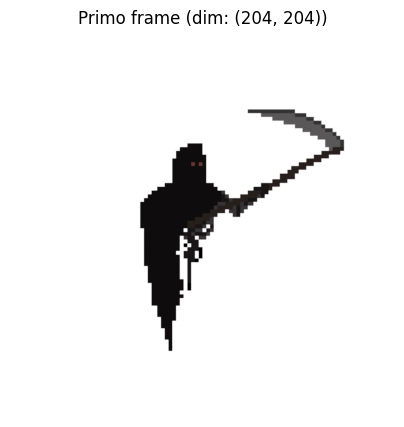


Test DataLoader per dimensioni (256, 256):
Primo frame shape: torch.Size([4, 4, 256, 256])
Numero di target frames per sequenza: [12, 12, 9, 12]
Metadati: {'action': ['shoots from invisible bow', 'shoots from invisible bow', 'is walking', 'shoots from invisible bow'], 'direction': ['South', 'North', 'East', 'West'], 'num_frames': [13, 13, 10, 13]}


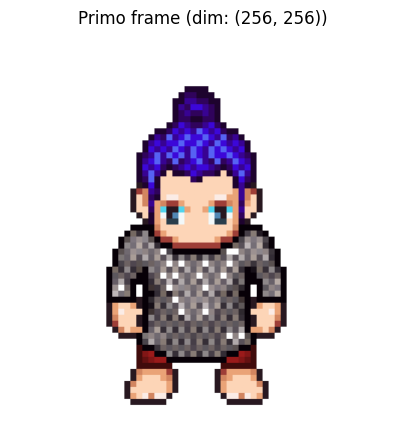


Test DataLoader per dimensioni (512, 512):
Primo frame shape: torch.Size([4, 4, 512, 512])
Numero di target frames per sequenza: [3, 3, 3, 3]
Metadati: {'action': ['is idle', 'perform an sword attack', 'falls down', 'is getting struck'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [4, 4, 4, 4]}


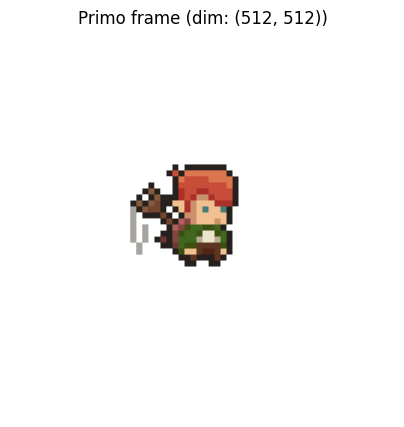


Test DataLoader per dimensioni (341, 341):
Primo frame shape: torch.Size([4, 4, 341, 341])
Numero di target frames per sequenza: [8, 7, 8, 7]
Metadati: {'action': ['swings machete to make an attack', 'is idle', 'walks', 'bites from left side'], 'direction': ['East', 'East', 'East', 'South'], 'num_frames': [9, 8, 9, 8]}


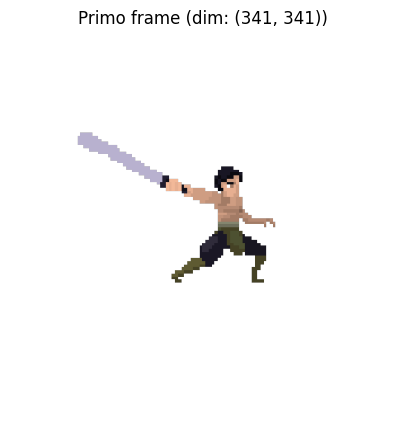


Test DataLoader per dimensioni (512, 256):
Primo frame shape: torch.Size([4, 4, 256, 512])
Numero di target frames per sequenza: [7, 7, 6, 7]
Metadati: {'action': ['is hanging with single hand in air', 'grows roots from the arrowhead', 'is making jumping sword attack', 'hits the target and sprouts thorns'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [8, 8, 7, 8]}


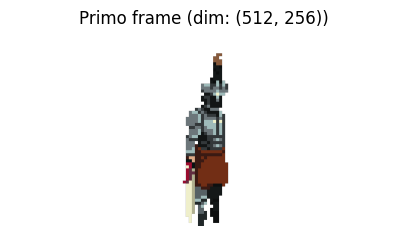


Test DataLoader per dimensioni (256, 128):
Primo frame shape: torch.Size([2, 4, 128, 256])
Numero di target frames per sequenza: [16, 18]
Metadati: {'action': ['hits the ground creating entangling roots', 'is attacking with sword'], 'direction': ['East', 'East'], 'num_frames': [17, 19]}


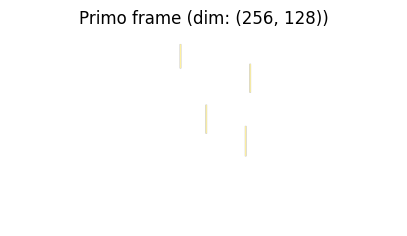


Test DataLoader per dimensioni (341, 170):
Primo frame shape: torch.Size([2, 4, 170, 341])
Numero di target frames per sequenza: [11, 9]
Metadati: {'action': ['is falling to his knees and begins to pray and then gets up', 'is sliding'], 'direction': ['East', 'East'], 'num_frames': [12, 10]}


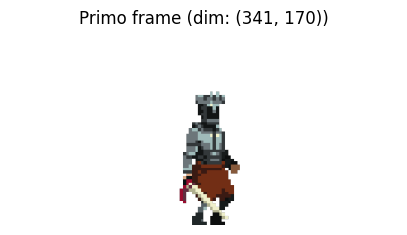


Test DataLoader per dimensioni (512, 341):
Primo frame shape: torch.Size([4, 4, 341, 512])
Numero di target frames per sequenza: [4, 5, 3, 5]
Metadati: {'action': ['is opening', 'is running', 'is idle', 'is running'], 'direction': ['West', 'West', 'West', 'West'], 'num_frames': [5, 6, 4, 6]}


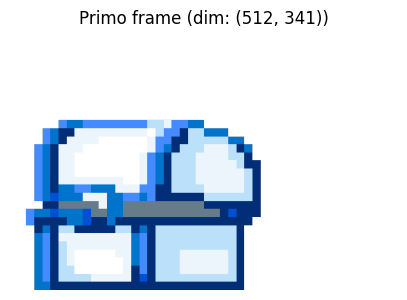


Test DataLoader per dimensioni (512, 158):
Primo frame shape: torch.Size([3, 4, 158, 512])
Numero di target frames per sequenza: [3, 4, 6]
Metadati: {'action': ['is charging', 'faints', 'is swinging a ball to attack'], 'direction': ['East', 'East', 'East'], 'num_frames': [4, 5, 7]}


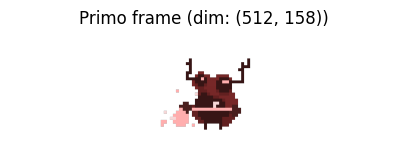


Test DataLoader per dimensioni (256, 170):
Primo frame shape: torch.Size([1, 4, 170, 256])
Numero di target frames per sequenza: [15]
Metadati: {'action': ['strikes a lighting in shape of a hand'], 'direction': ['West'], 'num_frames': [16]}


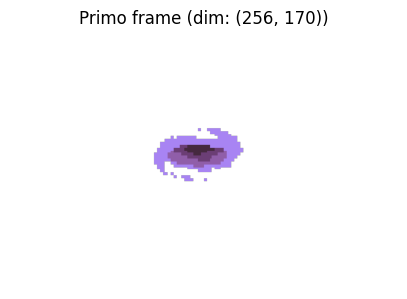


Test DataLoader per dimensioni (256, 347):
Primo frame shape: torch.Size([2, 4, 347, 256])
Numero di target frames per sequenza: [7, 7]
Metadati: {'action': ['is dancing', 'is dancing'], 'direction': ['West', 'South'], 'num_frames': [8, 8]}


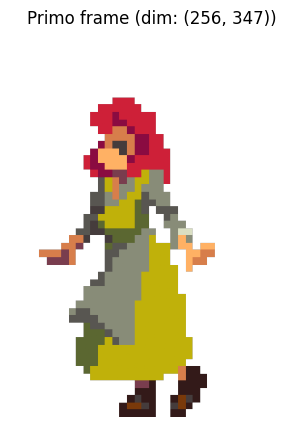


Test DataLoader per dimensioni (341, 146):
Primo frame shape: torch.Size([2, 4, 146, 341])
Numero di target frames per sequenza: [18, 18]
Metadati: {'action': ['falls to his knees and faints on the floor', 'defends himself by transforming his bow into shield made of roots'], 'direction': ['East', 'East'], 'num_frames': [19, 19]}


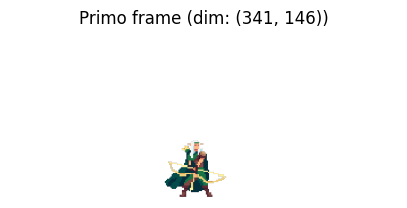


Test DataLoader per dimensioni (512, 106):
Primo frame shape: torch.Size([4, 4, 106, 512])
Numero di target frames per sequenza: [7, 2, 7, 7]
Metadati: {'action': ['is running', 'jumps up', 'rolls on the ground', 'is idle'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [8, 3, 8, 8]}


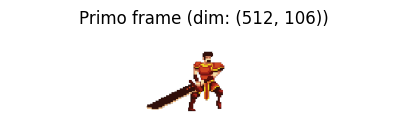


Test DataLoader per dimensioni (328, 146):
Primo frame shape: torch.Size([3, 4, 146, 328])
Numero di target frames per sequenza: [19, 18, 18]
Metadati: {'action': ['jumps up then falls down', 'disappears in whirlwind', 'swings his sword overhead then spins around to make combo attack'], 'direction': ['East', 'East', 'East'], 'num_frames': [20, 19, 19]}


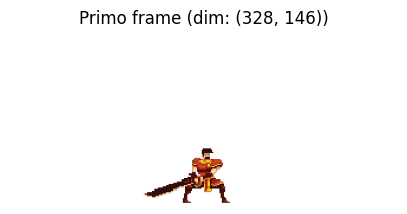


Test DataLoader per dimensioni (512, 131):
Primo frame shape: torch.Size([1, 4, 131, 512])
Numero di target frames per sequenza: [2]
Metadati: {'action': ['falls down'], 'direction': ['East'], 'num_frames': [3]}


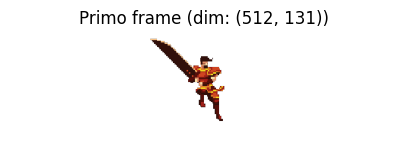


Test DataLoader per dimensioni (341, 150):
Primo frame shape: torch.Size([3, 4, 150, 341])
Numero di target frames per sequenza: [17, 9, 12]
Metadati: {'action': ['ignites his magic sword to make flame attack', 'defends himself with a sword', 'swings his sword overhead to attack'], 'direction': ['East', 'East', 'East'], 'num_frames': [18, 10, 13]}


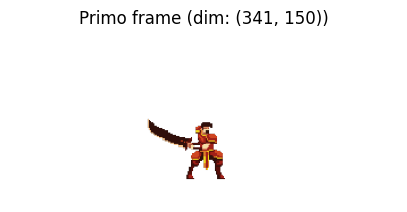


Test DataLoader per dimensioni (256, 113):
Primo frame shape: torch.Size([4, 4, 113, 256])
Numero di target frames per sequenza: [20, 31, 25, 26]
Metadati: {'action': ['is thrusting her sword double to make combo attack', 'creates water blob that shortly after splashes on ground and creates icy spikes', 'is fast swinging his swords then makes whirlwind', 'is thrusting her sword double and shoots a water splash from it'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [21, 32, 26, 27]}


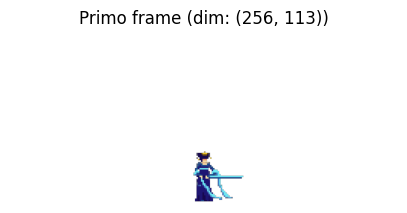


Test DataLoader per dimensioni (512, 227):
Primo frame shape: torch.Size([4, 4, 227, 512])
Numero di target frames per sequenza: [2, 7, 7, 5]
Metadati: {'action': ['jumps up', 'runs', 'is thrusting her sword in air', 'rolls'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [3, 8, 8, 6]}


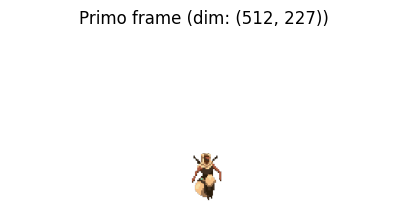


Test DataLoader per dimensioni (341, 151):
Primo frame shape: torch.Size([4, 4, 151, 341])
Numero di target frames per sequenza: [11, 11, 9, 17]
Metadati: {'action': ['heals herself', 'defends herself by creating ice wall', 'walks', 'is fast swinging his swords in combo attack'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [12, 12, 10, 18]}


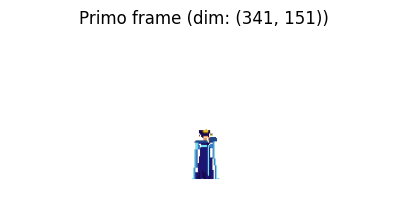


Test DataLoader per dimensioni (510, 511):
Primo frame shape: torch.Size([1, 4, 511, 510])
Numero di target frames per sequenza: [3]
Metadati: {'action': ['is getting struck'], 'direction': ['East'], 'num_frames': [4]}


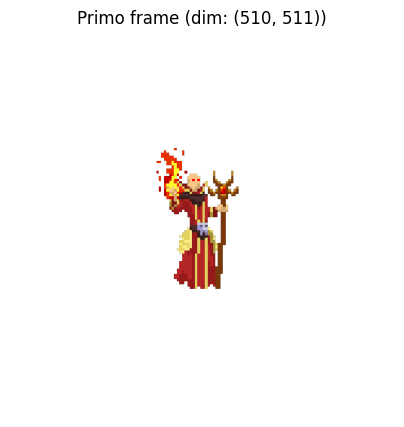


Test DataLoader per dimensioni (256, 190):
Primo frame shape: torch.Size([2, 4, 190, 256])
Numero di target frames per sequenza: [3, 8]
Metadati: {'action': ['walks', 'is idle'], 'direction': ['East', 'East'], 'num_frames': [4, 9]}


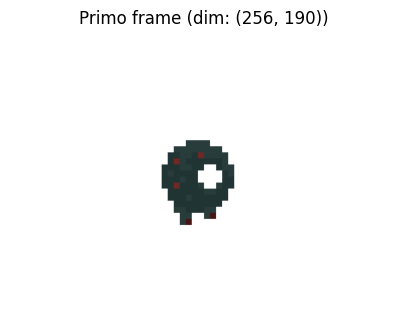


Test DataLoader per dimensioni (341, 127):
Primo frame shape: torch.Size([2, 4, 127, 341])
Numero di target frames per sequenza: [11, 11]
Metadati: {'action': ['faints and disappears', 'is making beam from his eye'], 'direction': ['East', 'East'], 'num_frames': [12, 12]}


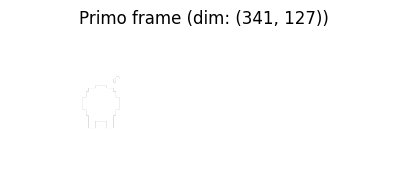


Test DataLoader per dimensioni (512, 192):
Primo frame shape: torch.Size([1, 4, 192, 512])
Numero di target frames per sequenza: [8]
Metadati: {'action': ['rolls'], 'direction': ['East'], 'num_frames': [9]}


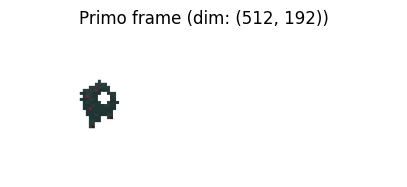


Test DataLoader per dimensioni (113, 113):
Primo frame shape: torch.Size([1, 4, 113, 113])
Numero di target frames per sequenza: [76]
Metadati: {'action': ['is rotating'], 'direction': ['unknown'], 'num_frames': [77]}


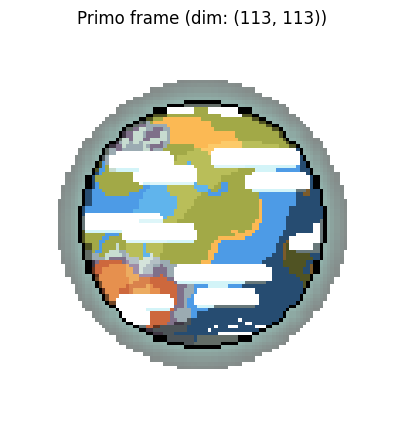


Test DataLoader per dimensioni (128, 128):
Primo frame shape: torch.Size([4, 4, 128, 128])
Numero di target frames per sequenza: [59, 59, 59, 59]
Metadati: {'action': ['intersect with each other to create a ribbon-like pattern', 'intersect with each other to create a ribbon-like pattern', 'intersect with each other to create a ribbon-like pattern', 'intersect with each other to create a ribbon-like pattern'], 'direction': ['unknown', 'unknown', 'unknown', 'unknown'], 'num_frames': [60, 60, 60, 60]}


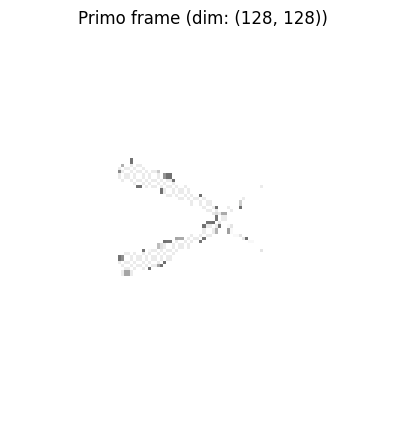


Test DataLoader per dimensioni (512, 170):
Primo frame shape: torch.Size([1, 4, 170, 512])
Numero di target frames per sequenza: [3]
Metadati: {'action': ['rotates'], 'direction': ['East'], 'num_frames': [4]}


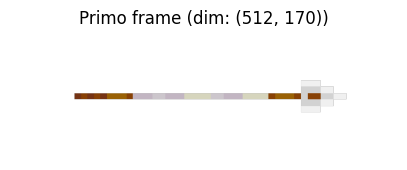


Test DataLoader per dimensioni (340, 340):
Primo frame shape: torch.Size([1, 4, 340, 340])
Numero di target frames per sequenza: [5]
Metadati: {'action': ['swing his sword to attack'], 'direction': ['East'], 'num_frames': [6]}


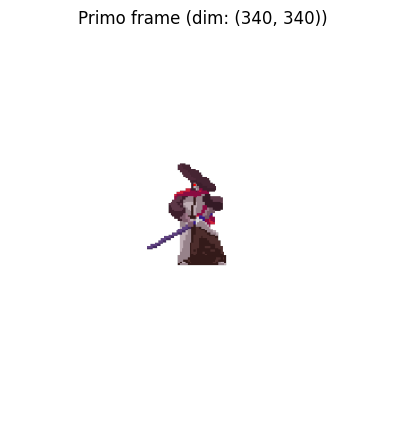


Test DataLoader per dimensioni (512, 354):
Primo frame shape: torch.Size([4, 4, 354, 512])
Numero di target frames per sequenza: [3, 3, 1, 3]
Metadati: {'action': ['perform an sword attack', 'swings his sword to make an attack', 'falls down', 'is getting struck'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [4, 4, 2, 4]}


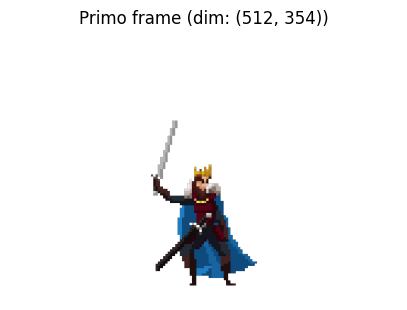


Test DataLoader per dimensioni (339, 237):
Primo frame shape: torch.Size([1, 4, 237, 339])
Numero di target frames per sequenza: [5]
Metadati: {'action': ['faints on the floor'], 'direction': ['East'], 'num_frames': [6]}


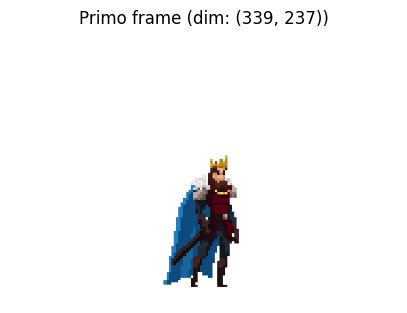


Test DataLoader per dimensioni (341, 236):
Primo frame shape: torch.Size([2, 4, 236, 341])
Numero di target frames per sequenza: [7, 7]
Metadati: {'action': ['runs', 'is idle'], 'direction': ['East', 'East'], 'num_frames': [8, 8]}


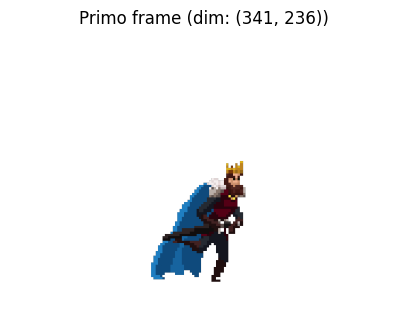


Test DataLoader per dimensioni (170, 164):
Primo frame shape: torch.Size([1, 4, 164, 170])
Numero di target frames per sequenza: [26]
Metadati: {'action': ['makes multiple special attacks with pink dagger'], 'direction': ['East'], 'num_frames': [27]}


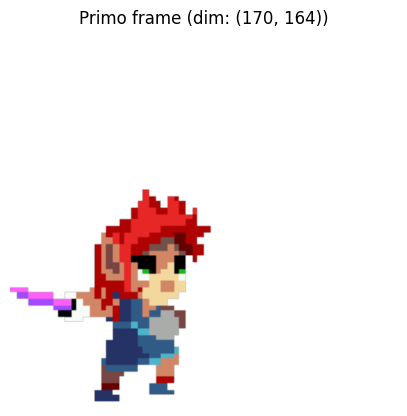


Test DataLoader per dimensioni (511, 512):
Primo frame shape: torch.Size([1, 4, 512, 511])
Numero di target frames per sequenza: [2]
Metadati: {'action': ['is getting struck'], 'direction': ['South'], 'num_frames': [3]}


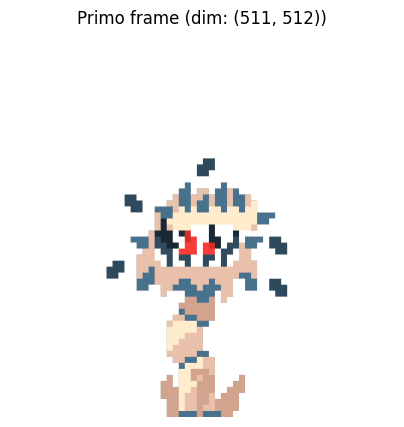


Test DataLoader per dimensioni (256, 82):
Primo frame shape: torch.Size([1, 4, 82, 256])
Numero di target frames per sequenza: [28]
Metadati: {'action': ['makes various attacks'], 'direction': ['East'], 'num_frames': [29]}


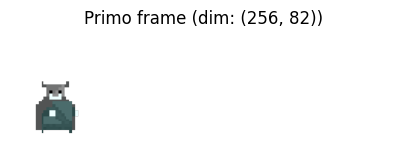


Test DataLoader per dimensioni (512, 164):
Primo frame shape: torch.Size([3, 4, 164, 512])
Numero di target frames per sequenza: [3, 5, 11]
Metadati: {'action': ['is idle', 'runs', 'is getting struct and disintegrates'], 'direction': ['East', 'East', 'East'], 'num_frames': [4, 6, 12]}


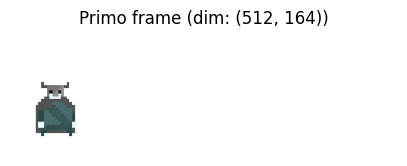


Test DataLoader per dimensioni (256, 255):
Primo frame shape: torch.Size([1, 4, 255, 256])
Numero di target frames per sequenza: [12]
Metadati: {'action': ['swings a scythe to perform an attack'], 'direction': ['East'], 'num_frames': [13]}


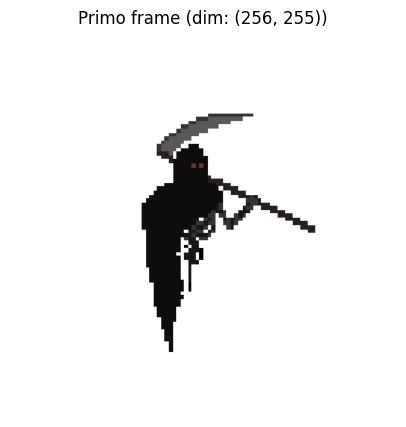


Test DataLoader per dimensioni (511, 511):
Primo frame shape: torch.Size([1, 4, 511, 511])
Numero di target frames per sequenza: [3]
Metadati: {'action': ['is idle'], 'direction': ['East'], 'num_frames': [4]}


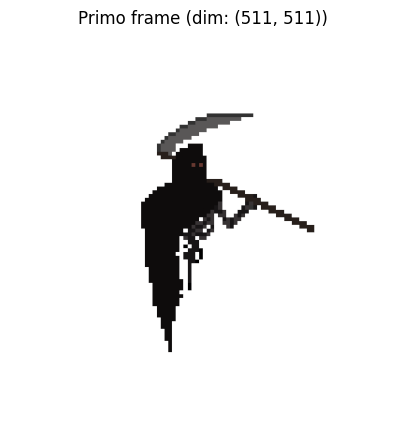


Test DataLoader per dimensioni (341, 208):
Primo frame shape: torch.Size([4, 4, 208, 341])
Numero di target frames per sequenza: [5, 7, 7, 6]
Metadati: {'action': ['is idle', 'makes arcane spell from his staff', 'cast a spell that creates magic orb', 'falls on knees and his staff breaks'], 'direction': ['East', 'East', 'East', 'East'], 'num_frames': [6, 8, 8, 7]}


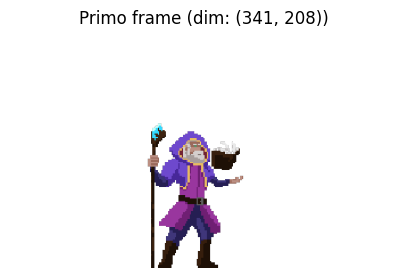


Test DataLoader per dimensioni (512, 348):
Primo frame shape: torch.Size([1, 4, 348, 512])
Numero di target frames per sequenza: [3]
Metadati: {'action': ['is getting struck'], 'direction': ['East'], 'num_frames': [4]}


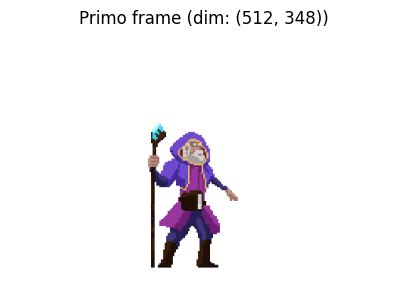


Test DataLoader per dimensioni (512, 284):
Primo frame shape: torch.Size([2, 4, 284, 512])
Numero di target frames per sequenza: [5, 4]
Metadati: {'action': ['is idle', 'is taking damage after hit'], 'direction': ['West', 'West'], 'num_frames': [6, 5]}


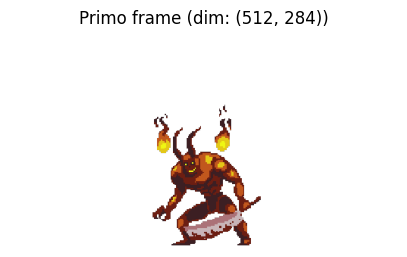


Test DataLoader per dimensioni (341, 187):
Primo frame shape: torch.Size([1, 4, 187, 341])
Numero di target frames per sequenza: [11]
Metadati: {'action': ['is walking'], 'direction': ['West'], 'num_frames': [12]}


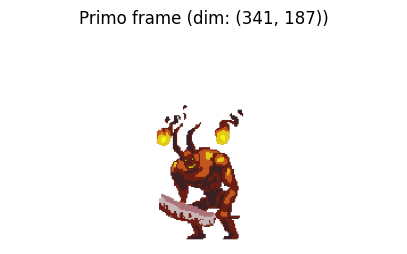


Test DataLoader per dimensioni (341, 189):
Primo frame shape: torch.Size([1, 4, 189, 341])
Numero di target frames per sequenza: [14]
Metadati: {'action': ['swings his cleaver to attack'], 'direction': ['West'], 'num_frames': [15]}


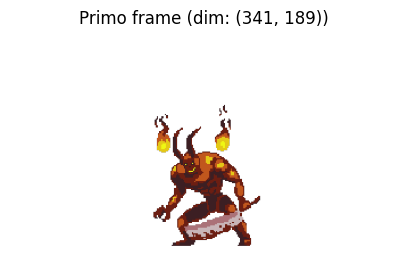


Test DataLoader per dimensioni (256, 142):
Primo frame shape: torch.Size([1, 4, 142, 256])
Numero di target frames per sequenza: [21]
Metadati: {'action': ['is disintegrating to ash in flames'], 'direction': ['West'], 'num_frames': [22]}


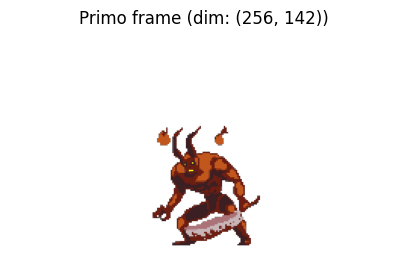


Test DataLoader per dimensioni (204, 155):
Primo frame shape: torch.Size([3, 4, 155, 204])
Numero di target frames per sequenza: [21, 24, 24]
Metadati: {'action': ['is idle', 'digs a hole and burrows himself into ground tunnel', 'digs a hole and burrows himself into ground tunnel'], 'direction': ['North-West', 'North-West', 'North-East'], 'num_frames': [22, 25, 25]}


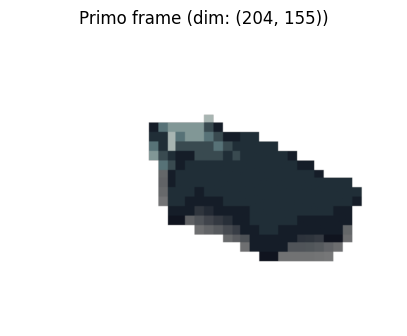


Test DataLoader per dimensioni (204, 154):
Primo frame shape: torch.Size([1, 4, 154, 204])
Numero di target frames per sequenza: [21]
Metadati: {'action': ['is idle'], 'direction': ['North-East'], 'num_frames': [22]}


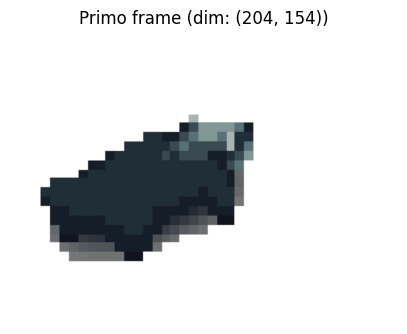


Test DataLoader per dimensioni (456, 341):
Primo frame shape: torch.Size([1, 4, 341, 456])
Numero di target frames per sequenza: [4]
Metadati: {'action': ['is moving'], 'direction': ['North-East'], 'num_frames': [5]}


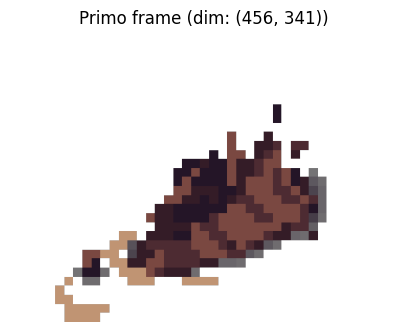


Test DataLoader per dimensioni (256, 205):
Primo frame shape: torch.Size([1, 4, 205, 256])
Numero di target frames per sequenza: [16]
Metadati: {'action': ['unborrows himself out the underground tunnel'], 'direction': ['North-East'], 'num_frames': [17]}


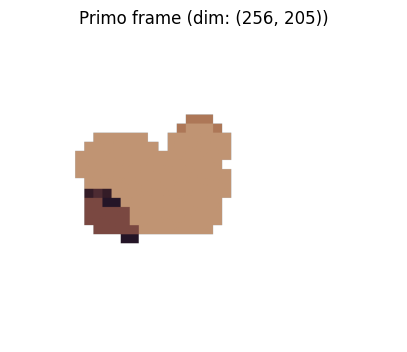


Test DataLoader per dimensioni (341, 256):
Primo frame shape: torch.Size([2, 4, 256, 341])
Numero di target frames per sequenza: [8, 8]
Metadati: {'action': ['is walking', 'is walking'], 'direction': ['North-East', 'North-West'], 'num_frames': [9, 9]}


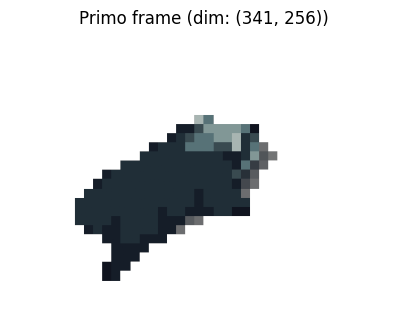


Test DataLoader per dimensioni (441, 341):
Primo frame shape: torch.Size([1, 4, 341, 441])
Numero di target frames per sequenza: [4]
Metadati: {'action': ['is moving'], 'direction': ['North-West'], 'num_frames': [5]}


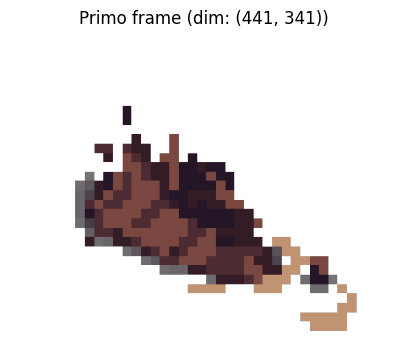


Test DataLoader per dimensioni (256, 196):
Primo frame shape: torch.Size([1, 4, 196, 256])
Numero di target frames per sequenza: [12]
Metadati: {'action': ['unburrows himself out the underground tunnel'], 'direction': ['North-West'], 'num_frames': [13]}


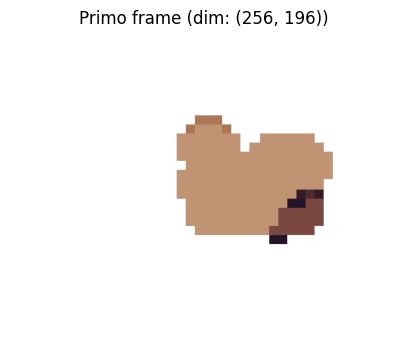


Test DataLoader per dimensioni (204, 157):
Primo frame shape: torch.Size([1, 4, 157, 204])
Numero di target frames per sequenza: [24]
Metadati: {'action': ['digs a hole and burrows himself into ground tunnel'], 'direction': ['South-East'], 'num_frames': [25]}


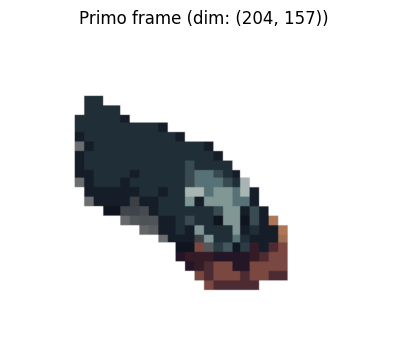

In [8]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None

    dimensions = batch[0]["dimensions"]
    if not all(item["dimensions"] == dimensions for item in batch):
        raise ValueError(f"Dimensioni non uniformi nel batch: {dimensions} vs {[item['dimensions'] for item in batch]}")

    first_frames = torch.stack([item["first_frame"] for item in batch])
    target_frames = [item["target_frames"] for item in batch]
    metadata = {
        "action": [item["metadata"]["action"] for item in batch],
        "direction": [item["metadata"]["direction"] for item in batch],
        "num_frames": [item["metadata"]["num_frames"] for item in batch]
    }

    return {
        "first_frame": first_frames,
        "target_frames": target_frames,
        "metadata": metadata,
        "dimensions": dimensions
    }

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = SpriteDataset(DATASET_PATH, transform=transform)

data_loaders = {}
dimension_groups = dataset.get_dimension_groups()

for dim, indices in dimension_groups.items():
    if len(indices) < 1:
        print(f"Gruppo di dimensioni {dim} vuoto, salto.")
        continue

    subset = Subset(dataset, indices)
    loader = DataLoader(
        subset,
        batch_size=4,
        shuffle=True,
        num_workers=0,  #È un parametro per il caricamento di dati in parallelo. Inizialmente impostato a 2, ora a 0(nullo) perché più veloce
        collate_fn=collate_fn
    )
    data_loaders[dim] = loader
    print(f"Creato DataLoader per dimensioni {dim} con {len(indices)} sequenze.")

for dim, loader in data_loaders.items():
    print(f"\nTest DataLoader per dimensioni {dim}:")
    for batch in loader:
        if batch is None:
            print("Batch vuoto, salto.")
            continue
        print("Primo frame shape:", batch["first_frame"].shape)
        print("Numero di target frames per sequenza:", [len(frames) for frames in batch["target_frames"]])
        print("Metadati:", batch["metadata"])

        plt.figure(figsize=(5, 5))
        plt.imshow(batch["first_frame"][0].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Primo frame (dim: {dim})")
        plt.axis("off")
        plt.show()
        break

## Cella 6: Definizione del Modello Animator2D
Questa cella definisce il modello `Animator2D`, composto da un `TextEncoder` (per codificare i metadati testuali) e un `FrameGenerator` (per generare i frame successivi).

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, model_name='t5-small', output_dim=512):
        super(TextEncoder, self).__init__()
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5EncoderModel.from_pretrained(model_name)
        t5_hidden_size = self.model.config.hidden_size
        self.projection = nn.Linear(t5_hidden_size, output_dim)

    def forward(self, actions, directions):
        prompts = [f"{action} {direction}" for action, direction in zip(actions, directions)]
        inputs = self.tokenizer(prompts, padding='longest', truncation=True, max_length=128, return_tensors='pt')
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        outputs = self.model(**inputs)
        text_embedding = outputs.last_hidden_state[:, 0]
        text_embedding = self.projection(text_embedding)
        return text_embedding

class FrameGenerator(nn.Module):
    def __init__(self, text_embedding_dim=512, base_channels=64):
        super(FrameGenerator, self).__init__()
        self.frame_encoder = nn.Sequential(
            nn.Conv2d(4, base_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 2 + text_embedding_dim, base_channels,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, 4, kernel_size=3, padding=1),
        )

    def forward(self, first_frame, text_embedding):
        frame_features = self.frame_encoder(first_frame)
        text_embedding = text_embedding.unsqueeze(-1).unsqueeze(-1)
        text_embedding = text_embedding.expand(-1, -1, frame_features.shape[2], frame_features.shape[3])
        combined = torch.cat([frame_features, text_embedding], dim=1)
        output_frame = self.decoder(combined)
        output_frame = torch.sigmoid(output_frame)
        return output_frame

class Animator2D(nn.Module):
    def __init__(self, text_embedding_dim=512):
        super(Animator2D, self).__init__()
        self.text_encoder = TextEncoder(output_dim=text_embedding_dim)
        self.frame_generator = FrameGenerator(text_embedding_dim=text_embedding_dim)

    def forward(self, first_frame, actions, directions, num_frames):
        # Supponiamo che text_embedding sia generato da actions e directions
        text_embedding = self.text_encoder(actions, directions)  # Implementazione ipotetica
        generated_frames = []
        current_frame = first_frame
        for _ in range(num_frames):  # Genera esattamente num_frames frame
            next_frame = self.frame_generator(current_frame, text_embedding)
            generated_frames.append(next_frame)
            current_frame = next_frame
        return torch.stack(generated_frames, dim=1)  # [1, num_frames, C, H, W]

## Cella 7: Definizione della Funzione di Loss
Questa cella definisce la funzione di loss `PixelArtLoss`, che combina L1 loss e edge loss per preservare i dettagli e i bordi netti del pixel art.

In [10]:
import torch
import torch.nn as nn

class PixelArtLoss(nn.Module):
    def __init__(self, alpha_weight=0.5, color_consistency_weight=0.05, background_alpha_weight=0.3):
        super(PixelArtLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.alpha_weight = alpha_weight
        self.color_weight = color_consistency_weight
        self.background_alpha_weight = background_alpha_weight

    def forward(self, generated, target, first_frame=None):
        # Perdita principale (MSE tra frame generati e target)
        mse_loss = self.mse(generated, target)

        # Penalità generale per valori di alfa bassi
        alpha_channel = generated[:, 3, :, :]  # Canale alfa dei frame generati
        alpha_loss = self.alpha_weight * torch.mean((1.0 - alpha_channel) ** 2)

        # Penalità per consistenza e trasparenza dello sfondo
        color_loss = 0.0
        background_alpha_loss = 0.0
        if first_frame is not None:
            # Consistenza del colore (solo RGB)
            generated_rgb = generated[:, :3, :, :]
            first_frame_rgb = first_frame[:3, :, :].unsqueeze(0).expand_as(generated_rgb)
            color_loss = self.color_weight * self.mse(generated_rgb, first_frame_rgb)

            # Penalità per lo sfondo trasparente
            first_frame_alpha = first_frame[3, :, :]  # Canale alfa del primo frame
            background_mask = (first_frame_alpha == 0).float()  # Maschera dello sfondo trasparente
            generated_alpha = generated[:, 3, :, :]  # Canale alfa dei frame generati
            background_alpha_loss = self.background_alpha_weight * torch.mean(
                background_mask * (generated_alpha ** 2)
            )

        total_loss = mse_loss + alpha_loss + color_loss + background_alpha_loss
        return total_loss

# Esempio di utilizzo
criterion = PixelArtLoss(alpha_weight=0.5, color_consistency_weight=0.05, background_alpha_weight=1.0)

## Cella 8: Addestramento del Modello
Questa cella configura e avvia l'addestramento del modello `Animator2D` usando i `DataLoader` per ogni gruppo di dimensioni.

In [14]:
from tqdm import tqdm
import torch
from collections import Counter
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import imageio

def train_model(model, data_loaders, criterion, optimizer, num_epochs=20, device='cuda', save_dir='checkpoints', max_frames_to_visualize=10, resume_checkpoint=None, save_every=1):
    model.to(device)

    # Crea le directory per checkpoint e visualizzazioni
    os.makedirs(save_dir, exist_ok=True)
    vis_dir = os.path.join(save_dir, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)

    # Inizializza l'epoca di partenza a 0
    start_epoch = 0

    # Carica il checkpoint se specificato
    if resume_checkpoint is not None:
        try:
            print(f"Caricamento del checkpoint: {resume_checkpoint}")
            checkpoint = torch.load(resume_checkpoint, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Checkpoint caricato con successo. Ripresa dell'addestramento dall'epoca {start_epoch+1}")
        except Exception as e:
            print(f"Errore nel caricamento del checkpoint: {e}")
            print("Inizializzazione del modello da zero.")

    # Riepilogo delle lunghezze delle sequenze per ogni dimensione (stampato una sola volta all'inizio)
    print("Distribuzione delle lunghezze delle sequenze per dimensione:")
    for dim in data_loaders.keys():
        data_loader = data_loaders[dim]
        num_frames_list = []
        for batch in data_loader:
            if batch is None:
                continue
            num_frames_list.extend(batch["metadata"]["num_frames"])
        frame_counts = Counter(num_frames_list)
        print(f"Dimensione {dim}:")
        if frame_counts:
            # Stampa ogni lunghezza senza frecce se ci sono 2 o meno lunghezze diverse
            if len(frame_counts) <= 2:
                for num_frames in sorted(frame_counts.keys()):
                    count = frame_counts[num_frames]
                    print(f"  - frame: {num_frames} | sequenze: {count}")
            else:
                # Trova il massimo e il minimo numero di sequenze
                counts = list(frame_counts.values())
                max_count = max(counts)
                min_count = min(counts)

                # Identifica le lunghezze con il conteggio massimo e minimo
                max_frames = [num_frames for num_frames, count in frame_counts.items() if count == max_count]
                min_frames = [num_frames for num_frames, count in frame_counts.items() if count == min_count]

                # In caso di parità, scegli il frame massimo/minimo in base al numero di frame
                max_frame = max(max_frames)  # Lunghezza con più frame tra quelle con conteggio massimo
                min_frame = min(min_frames)  # Lunghezza con meno frame tra quelle con conteggio minimo

                # Stampa ogni lunghezza con la freccia appropriata
                for num_frames in sorted(frame_counts.keys()):
                    count = frame_counts[num_frames]
                    arrow = ""
                    if count == max_count and num_frames == max_frame:
                        arrow = " ↑"  # Freccia in su per il massimo
                    elif count == min_count and num_frames == min_frame:
                        arrow = " ↓"  # Freccia in giù per il minimo
                    print(f"  - frame: {num_frames} | sequenze: {count}{arrow}")
        else:
            print("  - Nessuna sequenza disponibile")

    # Calcola il numero totale di batch per tutte le dimensioni
    total_batches_per_epoch = sum(len(data_loaders[dim]) for dim in data_loaders.keys())

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss_all_dims = 0.0
        total_batches_processed = 0

        # Barra di progresso per l'epoca
        with tqdm(total=total_batches_per_epoch, desc=f'Epoch {epoch+1}/{num_epochs}', unit="batch") as epoch_pbar:
            for dim in data_loaders.keys():
                data_loader = data_loaders[dim]
                total_batches_dim = len(data_loader)
                batches_processed_dim = 0

                for batch in data_loader:
                    if batch is None:
                        batches_processed_dim += 1
                        total_batches_processed += 1
                        epoch_pbar.set_postfix({
                            'dim': str(dim),
                            'batch': f'{batches_processed_dim}/{total_batches_dim}',
                            'loss': f'{total_loss_all_dims / total_batches_processed:.4f}' if total_batches_processed > 0 else '0.0000'
                        })
                        epoch_pbar.update(1)
                        continue

                    first_frame = batch["first_frame"].to(device)
                    target_frames = batch["target_frames"]
                    actions = batch["metadata"]["action"]
                    directions = batch["metadata"]["direction"]
                    num_frames_list = batch["metadata"]["num_frames"]

                    optimizer.zero_grad()
                    total_loss = 0.0
                    batch_size = len(first_frame)

                    # Processa ogni sequenza nel batch
                    for i in range(batch_size):
                        num_frames = num_frames_list[i]
                        target = torch.stack(target_frames[i]).to(device)
                        frames_to_generate = num_frames - 1

                        # Generazione dei frame
                        generated = model(
                            first_frame[i:i+1],
                            [actions[i]],
                            [directions[i]],
                            frames_to_generate
                        )

                        # Allinea target ai frame generati
                        if target.shape[0] < frames_to_generate:
                            continue
                        target = target[:frames_to_generate]

                        # Verifica delle dimensioni
                        if generated.shape[1] != target.shape[0]:
                            min_frames = min(generated.shape[1], target.shape[0])
                            if min_frames == 0:
                                continue
                            generated = generated[:, :min_frames]
                            target = target[:min_frames]

                        # Verifica delle dimensioni spaziali
                        if generated.shape[2:] != target.shape[1:]:
                            continue

                        # Calcolo della loss
                        loss = criterion(generated.squeeze(0), target)
                        total_loss += loss / batch_size

                    # Backpropagation
                    if total_loss > 0:
                        total_loss.backward()
                        optimizer.step()
                        total_loss_all_dims += total_loss.item()

                    batches_processed_dim += 1
                    total_batches_processed += 1
                    epoch_pbar.set_postfix({
                        'dim': str(dim),
                        'batch': f'{batches_processed_dim}/{total_batches_dim}',
                        'loss': f'{total_loss_all_dims / total_batches_processed:.4f}'
                    })
                    epoch_pbar.update(1)

        avg_loss_epoch = total_loss_all_dims / total_batches_processed if total_batches_processed > 0 else 0
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss_epoch:.4f}")

        # Salva un checkpoint dopo un certo numero di epoche
        current_epoch = epoch + 1
        if current_epoch % save_every == 0 or current_epoch == num_epochs:
            checkpoint_path = os.path.join(save_dir, f'animator2d_epoch_{current_epoch}.pth')
            torch.save({
                'epoch': current_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss_epoch,
            }, checkpoint_path)
            print(f"Checkpoint salvato: {checkpoint_path}")

        # Genera e salva esempi di frame per ogni dimensione
        model.eval()
        total_dims = len(data_loaders.keys())
        with torch.no_grad():
            # Barra di progresso per il salvataggio delle visualizzazioni
            print(f"Salvataggio di epoca {epoch+1} - In corso", end="")
            with tqdm(total=total_dims, desc="", unit="dim") as vis_pbar:
                for dim_idx, dim in enumerate(data_loaders.keys()):
                    data_loader = data_loaders[dim]
                    batch = random.choice(list(data_loader))
                    if batch is None:
                        vis_pbar.update(1)
                        continue

                    first_frame = batch["first_frame"].to(device)
                    actions = batch["metadata"]["action"]
                    directions = batch["metadata"]["direction"]
                    num_frames_list = batch["metadata"]["num_frames"]

                    # Scegli una sequenza casuale dal batch
                    idx = random.randint(0, len(first_frame) - 1)
                    num_frames = num_frames_list[idx]
                    frames_to_generate = num_frames - 1

                    # Genera i frame
                    generated = model(
                        first_frame[idx:idx+1],
                        [actions[idx]],
                        [directions[idx]],
                        frames_to_generate
                    )

                    # Converti i frame generati in immagini
                    generated = generated.squeeze(0).cpu()
                    first_frame_img = first_frame[idx].cpu()

                    # Funzione per convertire tensori in immagini
                    def tensor_to_image(tensor):
                        tensor = tensor[:3]  # Usa solo i canali RGB
                        tensor = tensor.permute(1, 2, 0)  # [H, W, C]
                        for c in range(tensor.shape[2]):
                            channel = tensor[:, :, c]
                            if channel.max() > channel.min():
                                tensor[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min())
                            else:
                                tensor[:, :, c] = channel - channel.min()
                        return (tensor.numpy() * 255).astype(np.uint8)

                    # Salva il primo frame
                    plt.figure(figsize=(5, 5))
                    plt.imshow(tensor_to_image(first_frame_img))
                    plt.title(f"Epoch {epoch+1} - Dim {dim} - Primo Frame")
                    plt.axis('off')
                    first_frame_path = os.path.join(vis_dir, f'epoch_{epoch+1}_dim_{dim}_first_frame.png')
                    plt.savefig(first_frame_path, bbox_inches='tight')
                    plt.close()

                    # Salva i frame generati
                    for i in range(min(max_frames_to_visualize, generated.shape[0])):
                        plt.figure(figsize=(5, 5))
                        plt.imshow(tensor_to_image(generated[i]))
                        plt.title(f"Epoch {epoch+1} - Dim {dim} - Frame Generato {i+1}")
                        plt.axis('off')
                        frame_path = os.path.join(vis_dir, f'epoch_{epoch+1}_dim_{dim}_generated_frame_{i+1}.png')
                        plt.savefig(frame_path, bbox_inches='tight')
                        plt.close()

                    # Crea e salva il GIF
                    gif_path = os.path.join(vis_dir, f'epoch_{epoch+1}_dim_{dim}_animation.gif')
                    def create_gif(frames, output_path, fps=10):
                        images = [tensor_to_image(frame) for frame in frames]
                        imageio.mimsave(output_path, images, fps=fps, loop=0)
                    create_gif(generated, gif_path, fps=10)

                    vis_pbar.set_postfix({
                        'dimensioni': f'({dim_idx+1}/{total_dims})'
                    })
                    vis_pbar.update(1)

            print(f"\rSalvataggio di epoca {epoch+1} - Completato")

        model.train()
        torch.cuda.empty_cache()

    # Salva il modello finale
    final_model_path = os.path.join(save_dir, 'animator2d_final.pth')
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss_epoch,
    }, final_model_path)
    print(f"Modello finale salvato: {final_model_path}")

    print("Addestramento completato.")
    return final_model_path

In [15]:
from tqdm import tqdm
import torch
import os

def fast_train_model(model, data_loaders, criterion, optimizer, num_epochs=50, device='cuda', save_dir='checkpoints', resume_checkpoint=None, save_every=10):
    model.to(device)

    # Crea la directory per i checkpoint
    os.makedirs(save_dir, exist_ok=True)

    # Inizializza l'epoca di partenza a 0
    start_epoch = 0

    # Carica il checkpoint se specificato
    if resume_checkpoint is not None:
        try:
            print(f"Caricamento del checkpoint: {resume_checkpoint}")
            checkpoint = torch.load(resume_checkpoint, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Checkpoint caricato con successo. Ripresa dell'addestramento dall'epoca {start_epoch+1}")
        except Exception as e:
            print(f"Errore nel caricamento del checkpoint: {e}")
            print("Inizializzazione del modello da zero.")

    # Calcola il numero totale di batch per tutte le dimensioni
    total_batches_per_epoch = sum(len(data_loaders[dim]) for dim in data_loaders.keys())

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss_all_dims = 0.0
        total_batches_processed = 0

        # Barra di progresso per l'epoca
        with tqdm(total=total_batches_per_epoch, desc=f'Epoch {epoch+1}/{num_epochs}', unit="batch") as epoch_pbar:
            for dim in data_loaders.keys():
                data_loader = data_loaders[dim]
                total_batches_dim = len(data_loader)
                batches_processed_dim = 0

                for batch in data_loader:
                    if batch is None:
                        batches_processed_dim += 1
                        total_batches_processed += 1
                        epoch_pbar.update(1)
                        continue

                    first_frame = batch["first_frame"].to(device)
                    target_frames = batch["target_frames"]
                    actions = batch["metadata"]["action"]
                    directions = batch["metadata"]["direction"]
                    num_frames_list = batch["metadata"]["num_frames"]

                    optimizer.zero_grad()
                    total_loss = 0.0
                    batch_size = len(first_frame)

                    # Processa ogni sequenza nel batch
                    for i in range(batch_size):
                        num_frames = num_frames_list[i]
                        target = torch.stack(target_frames[i]).to(device)
                        frames_to_generate = num_frames - 1

                        # Generazione dei frame
                        generated = model(
                            first_frame[i:i+1],
                            [actions[i]],
                            [directions[i]],
                            frames_to_generate
                        )

                        # Allinea target ai frame generati
                        if target.shape[0] < frames_to_generate:
                            continue
                        target = target[:frames_to_generate]

                        # Verifica delle dimensioni
                        if generated.shape[1] != target.shape[0]:
                            min_frames = min(generated.shape[1], target.shape[0])
                            if min_frames == 0:
                                continue
                            generated = generated[:, :min_frames]
                            target = target[:min_frames]

                        # Verifica delle dimensioni spaziali
                        if generated.shape[2:] != target.shape[1:]:
                            continue

                        # Calcolo della loss
                        loss = criterion(generated.squeeze(0), target)
                        total_loss += loss / batch_size

                    # Backpropagation
                    if total_loss > 0:
                        total_loss.backward()
                        optimizer.step()
                        total_loss_all_dims += total_loss.item()

                    batches_processed_dim += 1
                    total_batches_processed += 1
                    epoch_pbar.set_postfix({
                        'loss': f'{total_loss_all_dims / total_batches_processed:.4f}' if total_batches_processed > 0 else '0.0000'
                    })
                    epoch_pbar.update(1)

        avg_loss_epoch = total_loss_all_dims / total_batches_processed if total_batches_processed > 0 else 0
        print(f"Epoch {epoch+1}/{num_epochs}, Loss media: {avg_loss_epoch:.4f}")

        # Salva un checkpoint solo ogni save_every epoche
        current_epoch = epoch + 1
        if current_epoch % save_every == 0 or current_epoch == num_epochs:
            checkpoint_path = os.path.join(save_dir, f'animator2d_epoch_{current_epoch}.pth')
            torch.save({
                'epoch': current_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss_epoch,
            }, checkpoint_path)
            print(f"Checkpoint salvato: {checkpoint_path}")

        # Libera memoria CUDA
        torch.cuda.empty_cache()

    # Salva il modello finale
    final_model_path = os.path.join(save_dir, 'animator2d_final.pth')
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss_epoch,
    }, final_model_path)
    print(f"Modello finale salvato: {final_model_path}")

    print("Addestramento veloce completato.")
    return final_model_path

# Avvio dell'addestramento

In [18]:
# Avvio training in base alla modalità scelta
model = Animator2D()
criterion = PixelArtLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

if mode == "veloce":
    print("Avvio addestramento in modalità veloce...")
    final_model_path = fast_train_model(
        model,
        data_loaders,
        criterion,
        optimizer,
        num_epochs=50,
        device=device,
        save_dir=DRIVE_CHECKPOINTS_PATH + "_fast",
        save_every=1
    )
else:
    print("Avvio addestramento in modalità dettagliata...")
    final_model_path = train_model(
        model,
        data_loaders,
        criterion,
        optimizer,
        num_epochs=50,
        device=device,
        save_dir=DRIVE_CHECKPOINTS_PATH,
        save_every=1
    )
print(f"Modello finale salvato su Google Drive: {final_model_path}")

Avvio addestramento in modalità veloce...


Epoch 1/50: 100%|██████████| 128/128 [01:20<00:00,  1.58batch/s, loss=0.0770]


Epoch 1/50, Loss media: 0.0770
Checkpoint salvato: /content/drive/MyDrive/Animator2D/checkpoints_fast/animator2d_epoch_1.pth


Epoch 2/50: 100%|██████████| 128/128 [01:20<00:00,  1.59batch/s, loss=0.0747]


Epoch 2/50, Loss media: 0.0747
Checkpoint salvato: /content/drive/MyDrive/Animator2D/checkpoints_fast/animator2d_epoch_2.pth


Epoch 3/50: 100%|██████████| 128/128 [01:20<00:00,  1.59batch/s, loss=0.0742]


Epoch 3/50, Loss media: 0.0742
Checkpoint salvato: /content/drive/MyDrive/Animator2D/checkpoints_fast/animator2d_epoch_3.pth


Epoch 4/50:  35%|███▌      | 45/128 [00:45<01:23,  1.00s/batch, loss=0.1169]


KeyboardInterrupt: 

# Ripresa dell'addestramento da un checkpoint
Questa cella dimostra come riprendere l'addestramento del modello da un checkpoint salvato in precedenza.

In [ ]:
# Esempio di ripresa dell'addestramento da un checkpoint
def resume_training(checkpoint_path, additional_epochs=20):
    print(f"Caricamento del checkpoint da {checkpoint_path}")

    # Crea una nuova istanza del modello e del suo ottimizzatore
    model = Animator2D()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion = PixelArtLoss()

    # Carica le informazioni dal checkpoint per verificare l'epoca da cui riprendere
    checkpoint = torch.load(checkpoint_path, map_location=device)
    current_epoch = checkpoint['epoch']
    total_epochs = current_epoch + additional_epochs

    print(f"Ripresa dell'addestramento dall'epoca {current_epoch}")
    print(f"Verranno eseguite {additional_epochs} epoche aggiuntive per un totale di {total_epochs} epoche")

    # Avvia l'addestramento, specificando il checkpoint da cui riprendere
    save_dir = 'checkpoints_continued'
    final_model_path = train_model(
        model, data_loaders, criterion, optimizer,
        num_epochs=total_epochs, device=device,
        save_dir=save_dir, resume_checkpoint=checkpoint_path,
        save_every=5
    )

    return final_model_path

# Per utilizzare questa funzione, decommentare la riga seguente e specificare il percorso al checkpoint
# checkpoint_path = 'checkpoints/animator2d_epoch_20.pth'  # Modifica questo percorso
# final_model_path = resume_training(checkpoint_path, additional_epochs=30)

# Prossimi Passaggi
Dopo aver completato l'addestramento, puoi:
- Valutare il modello su un set di test o generare animazioni di esempio.
- Ottimizzare iperparametri come `edge_weight` nella loss o il learning rate.
- Migliorare l'architettura del modello, ad esempio aggiungendo più layer o sperimentando con GAN.

Se incontri errori, copia il messaggio di errore e condividilo per ricevere aiuto. Assicurati che il file zip del dataset abbia la struttura corretta:
- `image_transparent/spritesheet_0/frame_0.png`, `frame_1.png`, ecc.
- `sprite_metadata.json` con chiavi come `0`, `1`, e campi `folder_name`, `frames`, `action`, `direction`.

In [ ]:
# prompt: elimina una cartella fornendo il path

import shutil

def delete_folder(folder_path):
  """Deletes a folder and its contents.

  Args:
    folder_path: The path to the folder to delete.
  """
  try:
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' deleted successfully.")
  except FileNotFoundError:
    print(f"Folder '{folder_path}' not found.")
  except OSError as e:
    print(f"Error deleting folder '{folder_path}': {e}")

# Example usage:
folder_to_delete = ""  # Replace with the actual path
delete_folder(folder_to_delete)


In [ ]:
# prompt: scarica la cartella visualizations

from google.colab import files
import shutil

def download_folder(folder_path):
  """Downloads a folder as a zip file.

  Args:
      folder_path: The path to the folder to download.
  """
  try:
    shutil.make_archive('visualizations', 'zip', folder_path)
    files.download('visualizations.zip')
    print(f"Folder '{folder_path}' downloaded as visualizations.zip")
  except FileNotFoundError:
    print(f"Folder '{folder_path}' not found.")
  except OSError as e:
    print(f"Error downloading folder '{folder_path}': {e}")

# Example usage: Replace 'visualizations' with the actual folder path
download_folder('checkpoints/visualizations')
